In [10]:
import argparse
import errno
import os
import random
from importlib.metadata import requires
from timeit import timeit
import dill as pickle
import numpy as np
import scipy
import torch
import wandb
import yaml
from sympy import Matrix, MatrixSymbol, derive_by_array, symarray
from torch.distributions import Categorical

import environment
import importlib
importlib.reload(environment)
from environment import GridWorld
from subrl.utils.network import append_state
from subrl.utils.network import policy as agent_net
from visualization import Visu

# TODO: 1. remove dependence from matrix and could run multiple times in parallel, .sh script, run it on the server, check how to plot multiple on wb,
# can it plot different kappa's on the same with grouping
# apply a policy gradient algorithm, since the policy is deterministic, use policy iteration/value iteration since we know the dynamics
#
workspace = "subrl"

# 1) Load the config file
params = {
    "env": {
        "start": 1,
        "step_size": 0.1,
        "shape": {"x": 10, "y": 18},
        "horizon": 80,
        "node_weight": "constant",
        "disc_size": "small",
        "n_players": 3,
        "Cx_lengthscale": 2,
        "Cx_noise": 0.001,
        "Fx_lengthscale": 1,
        "Fx_noise": 0.001,
        "Cx_beta": 1.5,
        "Fx_beta": 1.5,
        "generate": False,
        "env_file_name": 'env_data.pkl',
        "cov_module": 'Matern',
        "stochasticity": 0.0,
        "domains": "two_room_2",
        "num": 1,  # 替代原来的args.env
        "initial": 80
    },
    "alg": {
        "gamma": 1,
        "type": "NM",
        "ent_coef": 0.0,
        "epochs": 140,
        "lr": 0.02
    },
    "common": {
        "a": 1,
        "subgrad": "greedy",
        "grad": "pytorch",
        "algo": "both",
        "init": "deterministic",
        "batch_size": 3000
    },
    "visu": {
        "wb": "disabled",
        "a": 1
    }
}
print(params)

# 2) Set the path and copy params from file
env_load_path = workspace + \
    "/environments/" + params["env"]["node_weight"]+ "/env_" + \
    str(1)

params['env']['num'] = 1 

epochs = params["alg"]["epochs"]

H = params["env"]["horizon"]
MAX_Ret = 2*(H+1)
if params["env"]["disc_size"] == "large":
    MAX_Ret = 3*(H+2)

# 3) Setup the environement
env = GridWorld(
    env_params=params["env"], common_params=params["common"], visu_params=params["visu"], env_file_path=env_load_path)
node_size = params["env"]["shape"]['x']*params["env"]["shape"]['y']

if params["env"]["node_weight"] == "entropy" or params["env"]["node_weight"] == "steiner_covering" or params["env"]["node_weight"] == "GP": 
    a_file = open(env_load_path +".pkl", "rb")
    data = pickle.load(a_file)
    a_file.close()

if params["env"]["node_weight"] == "entropy":
    env.cov = data
if params["env"]["node_weight"] == "steiner_covering":
    env.items_loc = data
if params["env"]["node_weight"] == "GP":
    env.weight = data

visu = Visu(env_params=params["env"])

env.get_horizon_transition_matrix()

# Agent's policy
if params["alg"]["type"]=="M" or params["alg"]["type"]=="SRL":
    agent = agent_net(2, env.action_dim)
else:
    agent = agent_net(H-1, env.action_dim)
optim = torch.optim.Adam(agent.parameters(), lr=params["alg"]["lr"])

for t_eps in range(epochs):
    mat_action = []
    mat_state = []
    mat_return = []
    marginal_return = []
    mat_done = []
    # print(t_eps)
    env.initialize(params["env"]["initial"])
    mat_state.append(env.state)
    init_state = env.state
    list_batch_state = []
    for h_iter in range(H-1):
        if params["alg"]["type"]=="M" or params["alg"]["type"]=="SRL":
            batch_state = mat_state[-1].reshape(-1, 1).float()
            # append time index to the state
            batch_state = torch.cat(
                [batch_state, h_iter*torch.ones_like(batch_state)], 1)
        else:
            batch_state = append_state(mat_state, H-1)
        action_prob = agent(batch_state)
        policy_dist = Categorical(action_prob)
        actions = policy_dist.sample()
        mat_action.append(actions)
        env.step(h_iter, actions)
        mat_state.append(env.state)  # s+1
        mat_return.append(env.weighted_traj_return(mat_state, type = params["alg"]["type"]))
        if h_iter ==0:
            marginal_return.append(mat_return[h_iter])
        else:
            marginal_return.append(mat_return[h_iter] - mat_return[h_iter-1])
        list_batch_state.append(batch_state)

    ###################
    # Compute gradients
    ###################

    states_visited = torch.vstack(list_batch_state).float()
   
    policy_dist = Categorical(agent(states_visited))
    log_prob = policy_dist.log_prob(torch.hstack(mat_action))
    batch_return = torch.hstack(marginal_return)/MAX_Ret

    # - 2*policy_dist.entropy().mean()
    J_obj = -1*(torch.mean(log_prob*batch_return) + params["alg"]["ent_coef"] *
                policy_dist.entropy().mean()/(t_eps+1))
    optim.zero_grad()
    J_obj.backward()
    optim.step()

    obj = env.weighted_traj_return(mat_state).float()
    print(visu.JPi_optimal, " mean ", obj.mean(), " max ",
          obj.max(), " median ", obj.median(), " min ", obj.min(), " ent ", policy_dist.entropy().mean().detach())


{'env': {'start': 1, 'step_size': 0.1, 'shape': {'x': 10, 'y': 18}, 'horizon': 80, 'node_weight': 'constant', 'disc_size': 'small', 'n_players': 3, 'Cx_lengthscale': 2, 'Cx_noise': 0.001, 'Fx_lengthscale': 1, 'Fx_noise': 0.001, 'Cx_beta': 1.5, 'Fx_beta': 1.5, 'generate': False, 'env_file_name': 'env_data.pkl', 'cov_module': 'Matern', 'stochasticity': 0.0, 'domains': 'two_room_2', 'num': 1, 'initial': 80}, 'alg': {'gamma': 1, 'type': 'NM', 'ent_coef': 0.0, 'epochs': 140, 'lr': 0.02}, 'common': {'a': 1, 'subgrad': 'greedy', 'grad': 'pytorch', 'algo': 'both', 'init': 'deterministic', 'batch_size': 3000}, 'visu': {'wb': 'disabled', 'a': 1}}
x_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001, 7.4999, 7.5001, 8.4999, 8.5001, 9.4999, 9.5001, 10.4999, 10.5001, 11.4999, 11.5001, 12.4999, 12.5001, 13.4999, 13.5001, 14.4999, 14.5001, 15.4999, 15.5001, 16.4999, 16.5001, 17.4999, 17.5001]
y_ticks [-0.5001, -0.499

In [18]:
def create_path_with_timesteps(states):
    """
    从轨迹数据创建带时间步的路径
    """
    # 将状态转换为带时间步的格式
    path_with_time = [(t, state.item()) for t, state in enumerate(states)]
    return path_with_time

In [19]:
mat_action = []
mat_state = []
mat_return = []
marginal_return = []
mat_done = []
# print(t_eps)
env.initialize(params["env"]["initial"])
mat_state.append(env.state)
init_state = env.state
list_batch_state = []
for h_iter in range(H-1):
    if params["alg"]["type"]=="M" or params["alg"]["type"]=="SRL":
        batch_state = mat_state[-1].reshape(-1, 1).float()
        # append time index to the state
        batch_state = torch.cat(
            [batch_state, h_iter*torch.ones_like(batch_state)], 1)
    else:
        batch_state = append_state(mat_state, H-1)
    action_prob = agent(batch_state)
    policy_dist = Categorical(action_prob)
    actions = policy_dist.sample()
    mat_action.append(actions)
    env.step(h_iter, actions)
    mat_state.append(env.state)  # s+1
    mat_return.append(env.weighted_traj_return(mat_state, type = params["alg"]["type"]))
    if h_iter ==0:
        marginal_return.append(mat_return[h_iter])
    else:
        marginal_return.append(mat_return[h_iter] - mat_return[h_iter-1])
    list_batch_state.append(batch_state)

从 3000 条轨迹中找到的最佳回报是: 59
最佳轨迹路径:
[(0, 80), (1, 79), (2, 78), (3, 77), (4, 76), (5, 75), (6, 93), (7, 111), (8, 129), (9, 147), (10, 148), (11, 149), (12, 149), (13, 148), (14, 149), (15, 149), (16, 131), (17, 130), (18, 129), (19, 111), (20, 110), (21, 109), (22, 108), (23, 90), (24, 72), (25, 54), (26, 36), (27, 36), (28, 37), (29, 38), (30, 39), (31, 40), (32, 22), (33, 4), (34, 4), (35, 5), (36, 4), (37, 3), (38, 2), (39, 2), (40, 3), (41, 3), (42, 3), (43, 4), (44, 3), (45, 3), (46, 3), (47, 2), (48, 2), (49, 1), (50, 0), (51, 1), (52, 1), (53, 0), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 2), (62, 3), (63, 3), (64, 2), (65, 2), (66, 2), (67, 2), (68, 1), (69, 2), (70, 3), (71, 4), (72, 4), (73, 3), (74, 3), (75, 3), (76, 3), (77, 4), (78, 3), (79, 2)]
x_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001, 7.4999, 7.5001, 8.4999, 8.5001, 9.4999, 9.5001, 10.4999, 10.5001, 11.

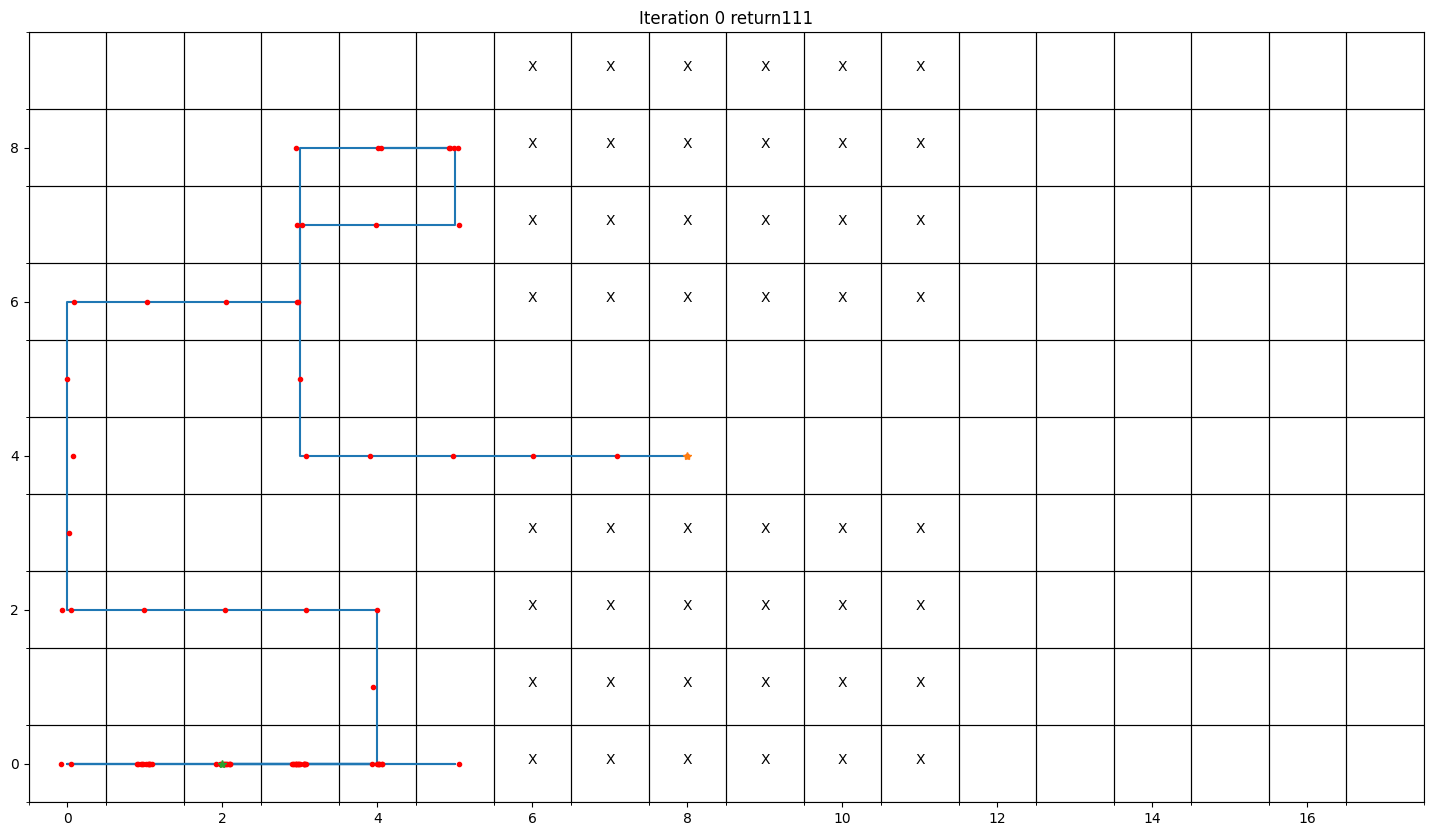

In [20]:
import importlib
import visualization
importlib.reload(visualization)
from visualization import Visu

# 3. 计算所有轨迹的回报并找到最佳轨迹
all_returns = env.weighted_traj_return(mat_state, type=params["alg"]["type"])
best_traj_index = torch.argmax(all_returns)
max_return = all_returns[best_traj_index]

num_trajectories = len(mat_state[-1])
print(f"从 {num_trajectories} 条轨迹中找到的最佳回报是: {max_return.item()}")

# 4. 提取最佳轨迹的状态
best_trajectory_states = [state_tensor[best_traj_index] for state_tensor in mat_state]

# 5. 创建路径并进行可视化
path = create_path_with_timesteps(best_trajectory_states)
print("最佳轨迹路径:")
print(path)

visu = Visu(env_params=params["env"])
visu.visu_path(path, env.Hori_ActionTransitionMatrix)